In [2]:
try:
    import cupy as xp
    from cupyx.scipy.fft import fftn, ifftn, fftfreq, fftshift, ifftshift
except:
    print("CuPy Import Failed.  Falling back to numpy+scipy.")
    import numpy as xp
    from scipy.fft import fftn, ifftn, fftfreq, fftshift, ifftshift
from scipy.special import hermite
import matplotlib.pyplot as plt
from PIL import Image

In [136]:
def cropped_fft(a, shape):
    rslt = fftshift(fftn(ifftshift(a)))
    axis0crop = (a.shape[0] - shape[0])//2
    axis1crop = (a.shape[1] - shape[1])//2
    return rslt[axis0crop:a.shape[0]-axis0crop, axis1crop:a.shape[1]-axis1crop]

def padded_ifft(a, shape):
    axis0pad = (shape[0] - a.shape[0])//2
    axis1pad = (shape[1] - a.shape[1])//2
    a_padded = xp.pad(a, ((axis0pad,axis0pad), (axis1pad,axis1pad)), 'constant')
    return fftshift(ifftn(ifftshift(a_padded)))

def one_step_of_GS(cur_pos, measured_pos, measured_mom_mag, GS_amp_mask, GS_phase_mask, kspace_scaling, pspace_unit_area, minimum_power):
    cur_mom = cropped_fft(cur_pos, measured_mom_mag.shape)*kspace_scaling
    next_mom = xp.abs(measured_mom_mag)*xp.exp(1j * xp.angle(cur_mom))
    next_pos_unscaled = padded_ifft(next_mom, measured_pos.shape)/kspace_scaling
    in_area_power= xp.sum(xp.square(GS_amp_mask*xp.abs(measured_pos)))*pspace_unit_area
    out_area_power = xp.sum(xp.square(xp.invert(GS_amp_mask)*xp.abs(next_pos_unscaled)))*pspace_unit_area
    in_scaling = xp.sqrt((1 - out_area_power)/in_area_power)
    out_scaling = 1
    mag_unnormalized = in_scaling*GS_amp_mask*xp.abs(measured_pos) + out_scaling*xp.invert(GS_amp_mask)*xp.abs(next_pos_unscaled)
    print(f"{in_area_power=},{out_area_power=}")
    if out_area_power > 1 - minimum_power:
        print("Below minimum power, rescaling")
        max_amp = xp.max(xp.abs(next_pos_unscaled))
        out_pos = next_pos_unscaled/max_amp
        out_pos = max_amp*out_pos*(1 - xp.abs(out_pos))
        out_area_power = xp.sum(xp.square(xp.invert(GS_amp_mask)*xp.abs(out_pos)))*pspace_unit_area
        in_scaling = xp.sqrt(minimum_power/in_area_power)
        out_scaling = xp.sqrt((1 - minimum_power)/out_area_power)
        mag_unnormalized = in_scaling*GS_amp_mask*xp.abs(measured_pos) + out_scaling*xp.invert(GS_amp_mask)*xp.abs(out_pos)
        # next_pos_unscaled = next_pos_unscaled*(1 - xp.random.rand(cur_pos.shape[0], cur_pos.shape[1]))
    print(f"{in_area_power=},{out_area_power=}")
    mag_unnormalized = in_scaling*GS_amp_mask*xp.abs(measured_pos) + out_scaling*xp.invert(GS_amp_mask)*xp.abs(next_pos_unscaled)
    # mag_unnormalized = GS_amp_mask*xp.abs(measured_pos) + xp.invert(GS_amp_mask)*xp.abs(next_pos_unscaled)
    print(xp.sqrt(xp.sum(xp.square(xp.abs(mag_unnormalized)))*pspace_unit_area))
    mag = mag_unnormalized/(xp.sqrt(xp.sum(xp.square(xp.abs(mag_unnormalized)))*pspace_unit_area))
    # mag = mag_unnormalized
    phase = GS_phase_mask*xp.angle(measured_pos) + xp.invert(GS_phase_mask)*xp.angle(next_pos_unscaled)
    next_pos = mag*xp.exp(1j * phase)
    # print("power", xp.sum(xp.square(xp.abs(next_pos)))*pspace_unit_area)
    return next_pos, next_mom

# def one_step_of_HPR(cur_pos, measured_mom_mag, diststep, GS_amp_mask, GS_phase_mask, beta):
#     alpha = 1/(1+beta)
#     cur_mom = fftn(ifftshift(cur_pos))*diststep**2/(2*xp.pi)
#     next_mom = xp.abs(measured_mom_mag)*xp.exp(1j * xp.angle(cur_mom))
#     next_pos_unscaled = fftshift(ifftn(next_mom))*(2*xp.pi/diststep**2)
#     alpha_scaled_mag = alpha*xp.abs(cur_pos)
#     next_pos_mag = xp.abs(next_pos_unscaled)
#     condition1 = xp.logical_and(GS_amp_mask,  alpha_scaled_mag < next_pos_mag)
#     condition2 = xp.logical_and(0 <= next_pos_unscaled, next_pos_mag <= alpha_scaled_mag)
#     condition3 = xp.logical_not(xp.logical_or(condition1, condition2))
#     final_next_pos = next_pos_unscaled*condition1 + (cur_pos - (1 - alpha)/alpha*next_pos_unscaled)*condition2 + (cur_pos - beta*next_pos_unscaled)*condition3
#     return final_next_pos, next_mom

In [121]:
def GS_algorithm(pos_amp, mom_amp_mag, GS_amp_mask, GS_phase_mask, num_iters, kspace_scaling, pspace_unit_area, minimum_power):
    phi = 2*xp.pi*xp.random.random(pos_amp.shape)
    cur_pos_amp = xp.abs(pos_amp)*xp.exp(1j*phi)
    # plt.pcolor(X, Y, xp.angle(cur_pos_amp))
    # plt.show()
    for i in range(0,num_iters):
        cur_pos_amp, cur_mom_amp = one_step_of_GS(cur_pos_amp, pos_amp, mom_amp_mag, GS_amp_mask, GS_phase_mask, kspace_scaling, pspace_unit_area, minimum_power)
        # plt.pcolor(xp.abs(cur_mom_amp).get())
        # plt.show()
        # if i % 1 == 0:
        #     plt.pcolor(xp.abs(fftshift(ifftn(cur_mom_amp, s=cur_pos_amp.shape))/kspace_scaling).get())
        #     plt.show()
        #     # plt.pcolor(xp.angle(fftshift(ifftn(cur_mom_amp, s=cur_pos_amp.shape))*(2*xp.pi/diststep**2)).get())
        #     # plt.show()
        #     # plt.pcolor(xp.angle(cur_pos_amp).get())
        #     # plt.show()
    return cur_pos_amp, cur_mom_amp

def convert_phase_to_SLM_image(phase_image, filename):
    LUT1560 = 226
    LUT1560_phase_image = phase_image*LUT1560/(2*xp.pi)
    LUT1560_phase_image_round = xp.array(xp.uint8(xp.round(xp.flip(LUT1560_phase_image, axis=0)).get()))
    # LUT1560_phase_image_round = xp.asarray(xp.round(LUT1560_phase_image).get(), dtype=xp.uint8)
    correction_array = xp.load("Correction.npy")
    # print(correction_array.shape)
    corrected_image = xp.mod(correction_array +  LUT1560_phase_image_round, LUT1560)
    # plt.pcolor(corrected_image.get())
    # xp.save(f'{filename}.npy', corrected_image, allow_pickle=True)
    im = Image.fromarray(xp.uint8(corrected_image.get()), mode="L")
    im.save(f'{filename}.bmp')

In [5]:
def gaussian(x,y, sigma):
    return 1/(2*xp.pi*xp.square(sigma))*xp.exp(-(xp.square(x)+xp.square(y))/(2*xp.square(sigma)))
def SLM_gaussian(x,y,x_cent=573, y_cent=725, spot_size=187.59):
    return gaussian(x-x_cent,y-y_cent,spot_size)
def hermite_gauss_1D(x, spot_size, radius_of_curve, k, n):
    poly = xp.poly1d(hermite(n))
    return poly(xp.sqrt(2)*x/spot_size)*xp.exp(-xp.square(x)*(1/xp.square(spot_size) + 1j*k/(2*radius_of_curve)))
def hermite_gauss_mode(x, y, spot_size, radius_of_curve, k, guoy_phase, n, m):
    return hermite_gauss_1D(x, spot_size, radius_of_curve, k, n)*hermite_gauss_1D(y, spot_size, radius_of_curve, k, m)*xp.exp(-1j*(n+m+1)*guoy_phase)
def top_hat(x,y,max_radius):
    radius = xp.square(x) + xp.square(y)
    return 1/(xp.sqrt(2*xp.pi)*max_radius)*xp.piecewise(radius, [radius < max_radius, radius >= max_radius], [1, 0])

In [129]:
def solve_one_mode(mode, spot_size=49.8278, mirror_ratio=50.0, minimum_power=0.1, xdim_mom=1272, ydim_mom=1024, xdim_pos=2544, ydim_pos=2048, x_cent = 0.325, y_cent = 0.000, pos_theta=0.11*xp.pi, SLM_x_cent = 727, SLM_y_cent = 574, SLM_spot_size=187.59):
    delta_k_x = 0.00131 # micro meter^-1/per_pixel
    delta_k_y = 0.00131
    diststepX = 2*xp.pi/(xdim_pos*delta_k_x)
    diststepY = 2*xp.pi/(ydim_pos*delta_k_y)
    assert(xdim_pos >= xdim_mom)
    assert((xdim_pos - xdim_mom) % 2 == 0)
    assert(ydim_pos >= ydim_mom)
    assert((ydim_pos - ydim_mom) % 2 == 0)
    kspace_unit_area = delta_k_x*delta_k_y
    px = fftfreq(xdim_pos, diststepX)
    py = fftfreq(ydim_pos, diststepY)
    rangeMinX = -diststepX*xdim_pos/2
    rangeMaxX = diststepX*xdim_pos/2
    rangeMinY = -diststepY*ydim_pos/2
    rangeMaxY = diststepY*ydim_pos/2
    kspace_scaling = diststepY*diststepX/(2*xp.pi)#*xp.sqrt(xdim_mom/xdim_pos*ydim_mom/ydim_pos)
    pspace_unit_area = diststepY*diststepX
    x = xp.linspace(rangeMinX, rangeMaxX, xdim_pos)
    y = xp.linspace(rangeMinY, rangeMaxY, ydim_pos)

    X, Y = xp.meshgrid(x,y)
    Xcpu, Ycpu = X.get(), Y.get()
    Px, Py = xp.meshgrid(px, py)
    axisXcrop = (xdim_pos - xdim_mom)//2
    axisYcrop = (ydim_pos - ydim_mom)//2
    # print(axisYcrop, ydim_mom + axisYcrop, axisXcrop, xdim_mom + axisXcrop)
    Px_sorted, Py_sorted = fftshift(Px)[axisYcrop:(ydim_mom+axisYcrop), axisXcrop:(xdim_mom+axisXcrop)], fftshift(Py)[axisYcrop:(ydim_mom+axisYcrop), axisXcrop:(xdim_mom+axisXcrop)]
    # print(Px_sorted.shape, (ydim_mom, xdim_mom))
    assert(Px_sorted.shape == (ydim_mom, xdim_mom))
    assert(Py_sorted.shape == (ydim_mom, xdim_mom))
    Px_sorted_cpu, Py_sorted_cpu = Px_sorted.get(), Py_sorted.get()

    GS_amp_mask = (X)**2 + (Y)**2 < (200)**2
    GS_phase_mask = GS_amp_mask

    
    # GS_amp_mask = X**2 + Y**2 < 3**2
    # GS_phase_mask = X**2 + Y**2 < 3**2

    X_rotated = xp.cos(pos_theta)*(X - x_cent) - xp.sin(pos_theta)*(Y - y_cent)
    Y_rotated = xp.sin(pos_theta)*(X - x_cent) + xp.cos(pos_theta)*(Y - y_cent)

    ODT_Axis = xp.cos(-0.75)*X + xp.sin(-0.75)*Y

    # unnormalized_pos_amp_mag = hermite_gauss_mode(X_rotated, Y_rotated, spot_size, 1.0, 0., 0., mode[0], mode[1]) #- hermite_gauss_mode(X, Y, 40.0, 1.0, 0., 0., mode[0], mode[1])
    unnormalized_pos_amp_mag = hermite_gauss_mode(X_rotated, Y_rotated, spot_size, 1.0, 0., 0., mode[0], mode[1]) + xp.cos(2*ODT_Axis*50/(50**2))*hermite_gauss_mode(X, Y, 10*spot_size, 1.0, 0., 0., mode[0], mode[1])
    # unnormalized_pos_amp_mag = xp.cos(2*ODT_Axis*50/(50**2))*hermite_gauss_mode(X, Y, 10*spot_size, 1.0, 0., 0., mode[0], mode[1])
    pos_amp_mag = 1/xp.sqrt(xp.sum(xp.square(xp.abs(unnormalized_pos_amp_mag)))*pspace_unit_area)*unnormalized_pos_amp_mag
    # mom_amp_mag = xp.abs(fftn(pos_amp_mag)*kspace_scaling)
    xSLMpixels, ySLMpixels = xp.round(Px_sorted/(Px_sorted[0][1] - Px_sorted[0][0]) + xdim_mom/2), xp.round(Py_sorted/(Py_sorted[1][0] - Py_sorted[0][0]) + ydim_mom/2)
    
    center_correction_kspace = xp.exp(1j*xp.pi/6*ySLMpixels)

    # print(xSLMpixels, ySLMpixels)
    unnormalized_mom_amp_mag = SLM_gaussian(xSLMpixels, ySLMpixels, x_cent=SLM_x_cent, y_cent=SLM_y_cent)
    mom_amp_mag = 1/xp.sqrt(xp.sum(xp.square(xp.abs(unnormalized_mom_amp_mag)))*kspace_unit_area)*unnormalized_mom_amp_mag
    SLM_bright_point_X = Px_sorted[SLM_y_cent, SLM_x_cent]
    SLM_bright_point_Y = Py_sorted[SLM_y_cent, SLM_x_cent]
    global_phase_correction_pos = xp.exp(1j*(SLM_bright_point_X*X + SLM_bright_point_Y*Y)*(2*xp.pi))
    pos_amp_mag = global_phase_correction_pos*pos_amp_mag

    print(xp.sum(xp.square(xp.abs(pos_amp_mag)))*pspace_unit_area)
    print(xp.sum(xp.square(xp.abs(cropped_fft(pos_amp_mag, (ydim_mom, xdim_mom))*kspace_scaling)))*kspace_unit_area)
    print(xp.sum(xp.square(xp.abs(mom_amp_mag)))*kspace_unit_area)
    print(xp.sum(xp.square(xp.abs(ifftn(mom_amp_mag, s=(ydim_pos, xdim_pos))/kspace_scaling)))*pspace_unit_area)


    # xDelta = int(xp.round(10.0*spot_size/diststepX))
    # yDelta = int(xp.round(10.0*spot_size/diststepY))

    # clippedXMin = xdim_pos//2 + int(x_cent/diststepX) - xDelta
    # clippedXMax = xdim_pos//2 + int(x_cent/diststepX) + xDelta
    # clippedYMin = ydim_pos//2 + int(y_cent/diststepY) - yDelta
    # clippedYMax = ydim_pos//2 + int(y_cent/diststepY) + yDelta

    xDelta = int(xp.round(100.0/diststepX))
    yDelta = int(xp.round(100.0/diststepY))

    clippedXMin = xdim_pos//2 - xDelta
    clippedXMax = xdim_pos//2 + xDelta
    clippedYMin = ydim_pos//2 - yDelta
    clippedYMax = ydim_pos//2 + yDelta

    plt.pcolor(Xcpu[clippedYMin:clippedYMax,clippedXMin:clippedXMax], Ycpu[clippedYMin:clippedYMax,clippedXMin:clippedXMax], xp.real((pos_amp_mag/global_phase_correction_pos)[clippedYMin:clippedYMax,clippedXMin:clippedXMax]).get())
    plt.colorbar()
    plt.show()
    # plt.pcolor(X, Y, xp.angle(pos_amp_mag))
    # plt.show()
    # plt.pcolor(Xcpu, Ycpu, GS_amp_mask)
    # plt.show()
    # plt.pcolor(Px_sorted_cpu, Py_sorted_cpu, mom_amp_mag.get())
    # plt.show()

    cur_pos_amp, cur_mom_amp = GS_algorithm(pos_amp_mag, mom_amp_mag, GS_amp_mask, GS_phase_mask, 200, kspace_scaling, pspace_unit_area, minimum_power)
    

    plt.pcolor(Xcpu[clippedYMin:clippedYMax,clippedXMin:clippedXMax], Ycpu[clippedYMin:clippedYMax,clippedXMin:clippedXMax], (xp.real(padded_ifft(cur_mom_amp, (ydim_pos, xdim_pos))/(kspace_scaling*global_phase_correction_pos))[clippedYMin:clippedYMax,clippedXMin:clippedXMax]).get())
    plt.colorbar()
    plt.show()
    # plt.pcolor(Xcpu, Ycpu, (xp.abs(fftshift(ifftn(cur_mom_amp, s=(ydim_pos, xdim_pos)))*GS_amp_mask/kspace_scaling)).get())
    # plt.show()
    # plt.pcolor(Xcpu[clippedYMin:clippedYMax,clippedXMin:clippedXMax], Ycpu[clippedYMin:clippedYMax,clippedXMin:clippedXMax], (xp.angle(fftshift(ifftn(cur_mom_amp, s=(ydim_pos, xdim_pos)))/(kspace_scaling*global_phase_correction_pos))[clippedYMin:clippedYMax,clippedXMin:clippedXMax]).get())
    # plt.show()

    return xp.angle(cur_mom_amp*center_correction_kspace)

0.9999999999999998
0.9999999999603665
1.0000000000000002
1.0000000000000004


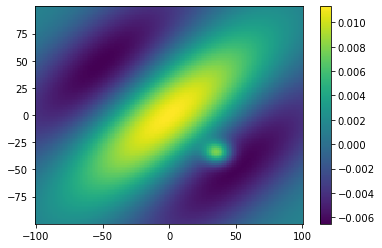

in_area_power=array(0.99971035),out_area_power=array(0.05883003)
in_area_power=array(0.99971035),out_area_power=array(0.05883003)
1.0
in_area_power=array(0.99971035),out_area_power=array(0.60357866)
in_area_power=array(0.99971035),out_area_power=array(0.60357866)
1.0
in_area_power=array(0.99971035),out_area_power=array(0.8427352)
in_area_power=array(0.99971035),out_area_power=array(0.8427352)
1.0
in_area_power=array(0.99971035),out_area_power=array(0.92530031)
in_area_power=array(0.99971035),out_area_power=array(0.92530031)
1.0
in_area_power=array(0.99971035),out_area_power=array(0.95306313)
Below minimum power, rescaling
in_area_power=array(0.99971035),out_area_power=array(0.57150931)
1.2783753827761029
in_area_power=array(0.99971035),out_area_power=array(0.96669451)
Below minimum power, rescaling
in_area_power=array(0.99971035),out_area_power=array(0.58117138)
1.2767879901701151
in_area_power=array(0.99971035),out_area_power=array(0.9734081)
Below minimum power, rescaling
in_area_pow

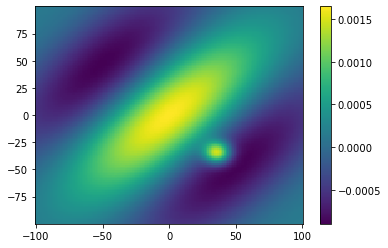

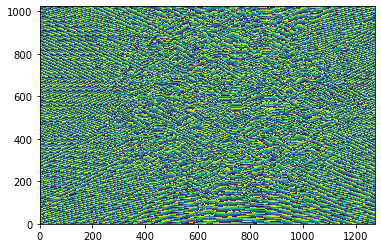

In [137]:
x_cent = 50.0*xp.cos(-0.75)
y_cent = 50.0*xp.sin(-0.75)

phase_mask = solve_one_mode(mode=(0,0), minimum_power=0.05, spot_size=10.0, x_cent=x_cent, y_cent=y_cent, xdim_pos=3816, ydim_pos=3072)
plt.pcolor(phase_mask.get())
convert_phase_to_SLM_image(phase_mask, f"cos_gaus_cent_and_spot")

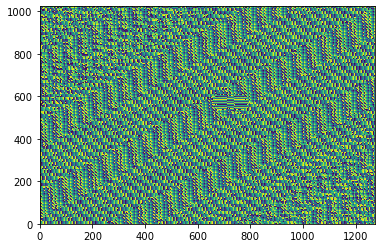

In [52]:
thetas = xp.pi*xp.linspace(0.0, 2.00, 20)
for theta in thetas:
    phase_mask = solve_one_mode(mode=(2,0), pos_theta=theta)
    plt.pcolor(phase_mask.get())
    theta_pi = theta/xp.pi
    convert_phase_to_SLM_image(phase_mask, f"TEM20_{theta_pi=:.2f}")

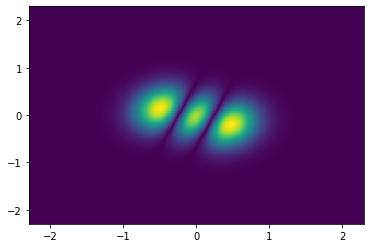

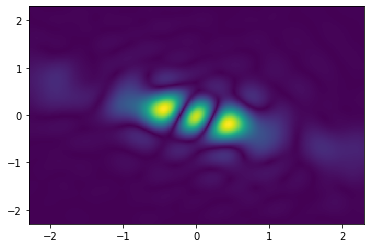

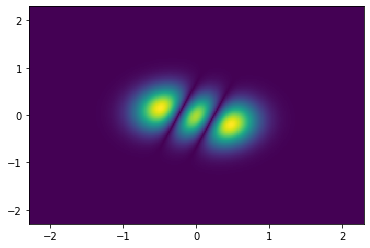

KeyboardInterrupt: 

In [213]:
translates = xp.linspace(-0.02, 0.02, 10)
unit = [xp.sin(0.11*xp.pi), xp.cos(0.11*xp.pi)]
for tranlate in translates:
    x_cent = 0.003 + unit[0]*tranlate
    y_cent = tranlate*unit[1]
    phase_mask = solve_one_mode(mode=(2,0), power_ratio=0.01, xdim_pos=4544, ydim_pos=4048, pos_theta=0.11*xp.pi, x_cent=x_cent, y_cent=y_cent)
    # plt.pcolor(phase_mask.get())
    # power_fraction = float(power_fraction)
    # convert_phase_to_SLM_image(phase_mask, f"TEM20_{x_cent=:.4f}{y_cent=:.4f}")

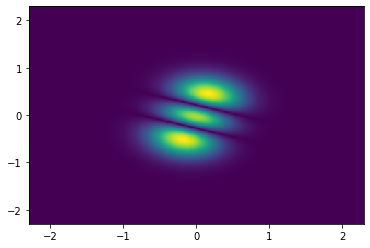

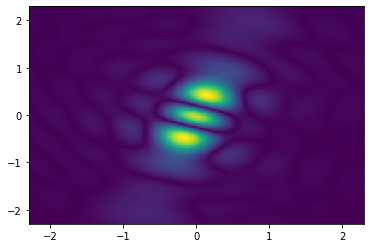

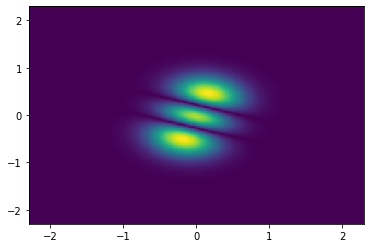

KeyboardInterrupt: 

In [214]:
translates = xp.linspace(-0.02, 0.02, 10)
unit = [xp.sin(0.11*xp.pi), xp.cos(0.11*xp.pi)]
for tranlate in translates:
    x_cent = 0.003 + unit[0]*tranlate
    y_cent = tranlate*unit[1]
    phase_mask = solve_one_mode(mode=(0,2), power_ratio=0.01, xdim_pos=4544, ydim_pos=4048, pos_theta=0.11*xp.pi, x_cent=x_cent, y_cent=y_cent)
    # plt.pcolor(phase_mask.get())
    # power_fraction = float(power_fraction)
    # convert_phase_to_SLM_image(phase_mask, f"TEM20_{x_cent=:.4f}{y_cent=:.4f}")

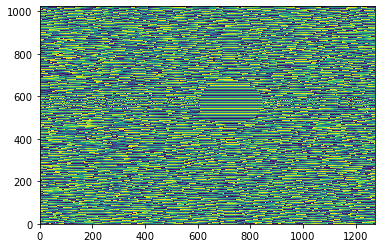

In [43]:
spot_size = 0.46
x_cent = 0.003 
y_cent = 0.000
SLM_x_cent = 727
SLM_y_cent = 574
SLM_spot_sizes = 188 + xp.arange(-10,10,2)
for SLM_spot_size in SLM_spot_sizes:
    phase_mask = solve_one_mode(spot_size, 50.0, x_cent=x_cent, y_cent=y_cent, SLM_x_cent=SLM_x_cent, SLM_y_cent=SLM_y_cent, SLM_spot_size=SLM_spot_size)
    plt.pcolor(phase_mask.get())
    SLM_spot_size = int(SLM_spot_size)
    convert_phase_to_SLM_image(phase_mask, f"NEWTEM00_{spot_size=:.3f}_{SLM_x_cent=}_{SLM_y_cent=}_{SLM_spot_size}")

In [ ]:
spot_size_choice = xp.linspace(0.5, 8.0, 40)
transmited_power_series = []
chi_squared_series = []
GS_amp_mask_size_series = []
for spot_size in spot_size_choice:
    transmited_power, chi_squared, GS_amp_mask_size = solve_one_mode(spot_size, 5.0, 3.0)
    transmited_power_series.append(transmited_power)
    chi_squared_series.append(chi_squared)
    GS_amp_mask_size_series.append(GS_amp_mask_size)

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

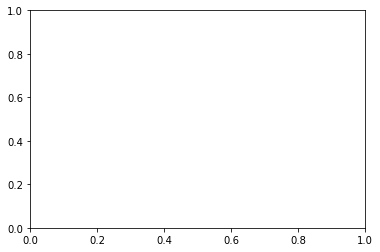

In [ ]:
fig, ax = plt.subplots()
i = 0
while i < 40:
    ax.plot(100*transmited_power_series[i], label=f'Spot size {spot_size_choice[i]:.2f}')
    i += 4
ax.legend()
ax.set_title('Transmitted Power against GS Iteration for SLM spot size 5$mm^{-1}$')
ax.set_xlabel('Iteration Number')
ax.set_ylabel(r'% of Power Transmitted')
plt.savefig('Plots/PowerTransmittedBroad5mm3mf.pdf')
plt.show()

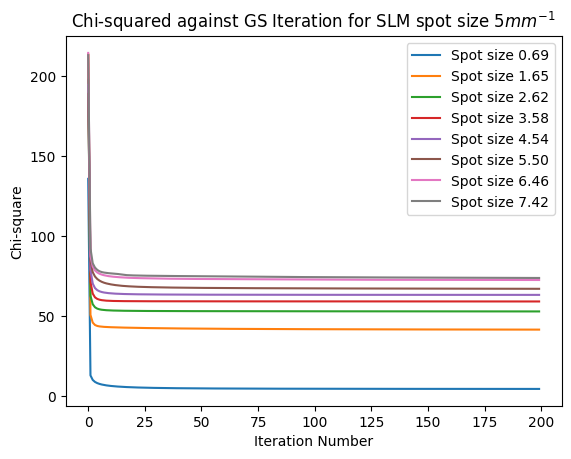

In [ ]:
fig, ax = plt.subplots()
i = 1
while i < 40:
    ax.plot(chi_squared_series[i], label=f'Spot size {spot_size_choice[i]:.2f}')
    i += 5
ax.legend()
ax.set_title('Chi-squared against GS Iteration for SLM spot size 5$mm^{-1}$')
ax.set_xlabel('Iteration Number')
ax.set_ylabel(r'Chi-square')
plt.savefig('Plots/ChiSquaredBroad5mm3mf.pdf')
plt.show()

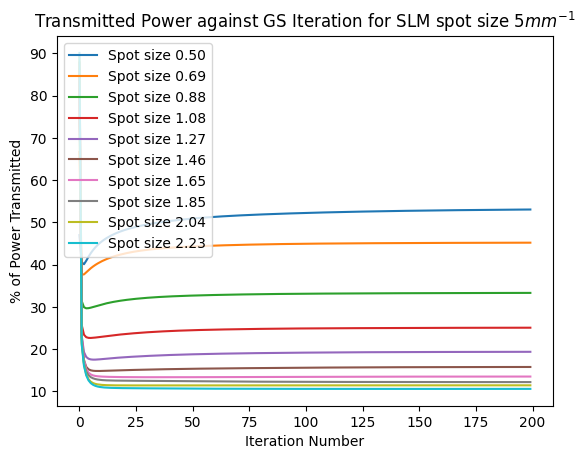

In [ ]:
fig, ax = plt.subplots()
i = 0
while i < 10:
    ax.plot(100*transmited_power_series[i], label=f'Spot size {spot_size_choice[i]:.2f}')
    i += 1
ax.legend()
ax.set_title('Transmitted Power against GS Iteration for SLM spot size 5$mm^{-1}$')
ax.set_xlabel('Iteration Number')
ax.set_ylabel(r'% of Power Transmitted')
plt.savefig('Plots/PowerTransmittedNarrow5mm3mf.pdf')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


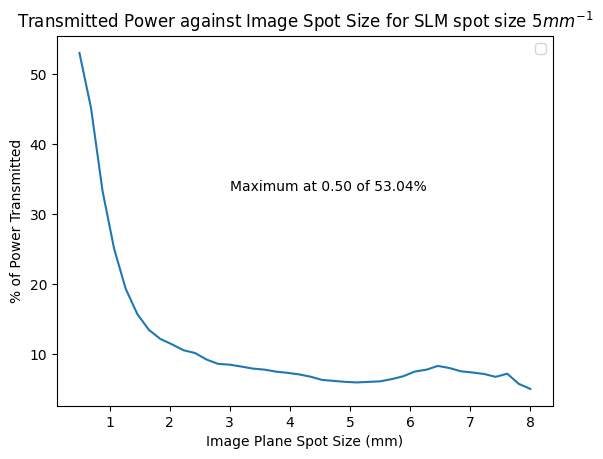

In [ ]:
fig, ax = plt.subplots()
ax.plot(spot_size_choice, 100*xp.array([transmited_power[199] for transmited_power in transmited_power_series]))
ax.legend()
ax.set_title('Transmitted Power against Image Spot Size for SLM spot size 5$mm^{-1}$')
ax.set_xlabel('Image Plane Spot Size (mm)')
ax.set_ylabel(r'% of Power Transmitted')
transmitions = [transmited_power[199] for transmited_power in transmited_power_series]
max_index = transmitions.index(max(transmitions))
plt.text(3,33.369, f'Maximum at {spot_size_choice[max_index]:.2f} of {100*transmited_power_series[max_index][199]:.2f}%')
plt.savefig('Plots/PowerTransmittedVSSpotSize5mm3mf.pdf')
plt.show()

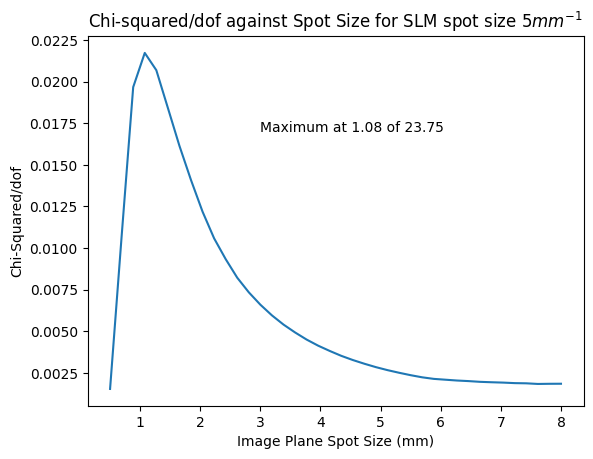

In [ ]:
fig, ax = plt.subplots()
ax.plot(spot_size_choice, xp.array([chi_squared[199] for chi_squared in chi_squared_series])/GS_amp_mask_size_series)
ax.set_title('Chi-squared/dof against Spot Size for SLM spot size 5$mm^{-1}$')
ax.set_xlabel('Image Plane Spot Size (mm)')
ax.set_ylabel(r'Chi-Squared/dof')
chi_squareds = xp.array([chi_squared[199] for chi_squared in chi_squared_series])/GS_amp_mask_size_series
max_index = list(chi_squareds).index(max(chi_squareds))
plt.text(3,0.017, f'Maximum at {spot_size_choice[max_index]:.2f} of {chi_squared_series[max_index][199]:.2f}')
plt.savefig('Plots/ChisquareddofVSSpotSize5mm3mf.pdf')
plt.show()

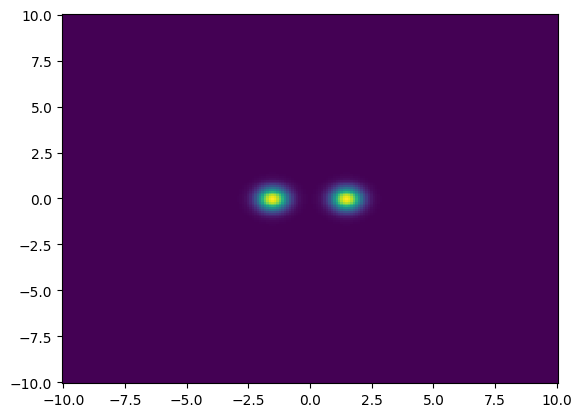

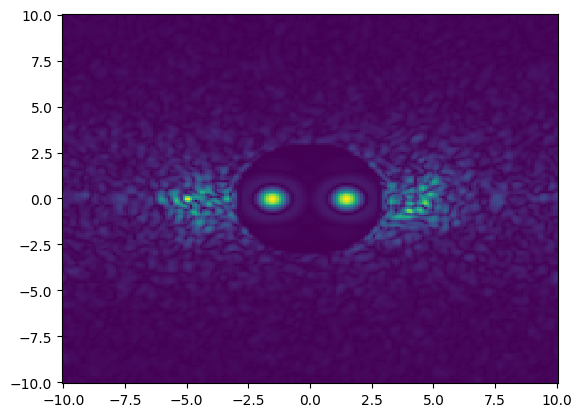

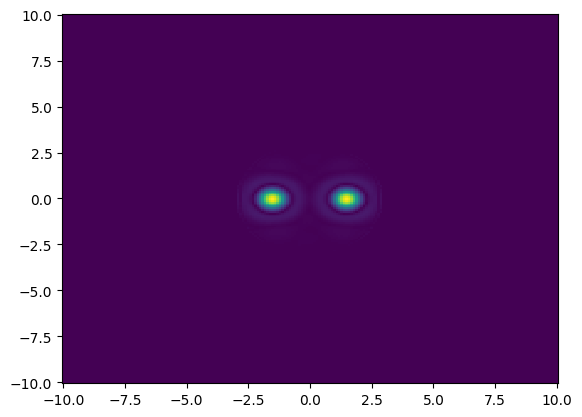

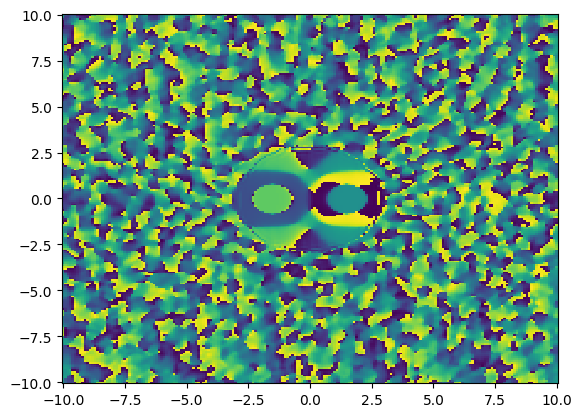

(array([0.91689632, 0.42518308, 0.35408506, 0.32264925, 0.30661785,
        0.29758956, 0.29225264, 0.28888337, 0.2865852 , 0.28489795,
        0.28358162, 0.28250891, 0.2816122 , 0.28085466, 0.28021415,
        0.27967537, 0.27922661, 0.2788584 , 0.2785624 , 0.27833003,
        0.27815157, 0.27801646, 0.27791433, 0.27783625, 0.27777516,
        0.27772591, 0.27768493, 0.27764982, 0.27761898, 0.27759137,
        0.27756633, 0.27754344, 0.27752241, 0.27750308, 0.2774853 ,
        0.27746895, 0.27745391, 0.27744005, 0.27742725, 0.27741536,
        0.27740422, 0.27739369, 0.27738365, 0.27737394, 0.27736447,
        0.27735513, 0.27734583, 0.27733649, 0.27732705, 0.27731745,
        0.27730767, 0.27729766, 0.27728741, 0.27727691, 0.27726614,
        0.2772551 , 0.27724381, 0.27723226, 0.27722046, 0.27720841,
        0.27719612, 0.2771836 , 0.27717086, 0.27715791, 0.27714478,
        0.27713146, 0.27711798, 0.27710435, 0.27709058, 0.27707668,
        0.27706267, 0.27704857, 0.27703437, 0.27

In [ ]:
solve_one_mode(0.3, 5.0, 1.5)

In [ ]:
# plt.pcolor(Px_sorted, Py_sorted, xp.angle(cur_mom_amp)*(2*xp.pi/diststep**2))
# plt.show()

In [ ]:
# phi = 2*xp.pi*xp.random.random((n,n))
# cur_pos_amp = pos_amp_mag*xp.exp(1j*phi)
# for i in range(0,200):
#     cur_pos_amp, cur_mom_amp = one_step_of_HPR(cur_pos_amp, mom_amp_mag, diststep, GS_amp_mask, GS_phase_mask, 1.0)
#     # print(xp.sum(xp.square(xp.abs(new_pos_amp)))*diststep**2)
#     # plt.pcolor(Px_sorted, Py_sorted, xp.abs(cur_mom_amp))
#     if i % 10 == 0:
#         plt.pcolor(X, Y, xp.abs(fftshift(ifftn(cur_mom_amp))*(2*xp.pi/diststep**2)))
#         plt.show()
#         plt.pcolor(X, Y, xp.angle(fftshift(ifftn(cur_mom_amp))*(2*xp.pi/diststep**2)))
#         plt.show()
#         plt.pcolor(X, Y, xp.angle(cur_pos_amp)*(2*xp.pi/diststep**2))
#         plt.show()

In [ ]:
# print(xp.sum(xp.square(xp.abs(cur_mom_amp)))*delta_k**2)
# print(xp.sum(xp.square(xp.abs(ifftn(cur_mom_amp)*(2*xp.pi/diststep**2))))*diststep**2)

In [ ]:
# # plt.pcolor(X.get(), Y.get(), fftshift(xp.abs(cur_mom_amp)).get())
# plt.pcolor(Px_sorted, Py_sorted, fftshift(xp.angle(cur_mom_amp)))

In [ ]:
# line = 0.02*X
# phase = xp.arctan2(xp.sin(line), 1 + xp.cos(line))
# plt.pcolor(Px_sorted, Py_sorted, fftshift(line))
# plt.show()
# plt.pcolor(Px_sorted, Py_sorted, fftshift(phase))

In [ ]:
# plt.pcolor(Px_sorted, Py_sorted, xp.abs(fftshift(ifftn(mom_amp_mag*xp.exp(1j*phase)))))

In [ ]:
# plt.pcolor(Px_sorted, Py_sorted, xp.abs(fftshift(ifftn(mom_amp_mag))))
# plt.show()
# plt.pcolor(Px_sorted, Py_sorted, xp.abs(fftshift(ifftn(mom_amp_mag*xp.exp(1j*line)))))

In [ ]:
# plt.pcolor(X, Y, unnormalized_gaussian(X+1.,Y,1.0))
# plt.show()
# plt.pcolor(Px_sorted, Py_sorted, fftshift(xp.abs(fftn(fftshift(unnormalized_gaussian(X+1.,Y,1.0))))))

In [ ]:
# plt.pcolor(Px_sorted, Py_sorted, fftshift(xp.angle(fftn(fftshift(unnormalized_gaussian(X,Y,1.0))))))

In [ ]:
# fftshift(xp.angle(fftn(unnormalized_gaussian(X+1.,Y,1.0))))[80:120, 80:120]